# Comet Experiment Management - Getting Started
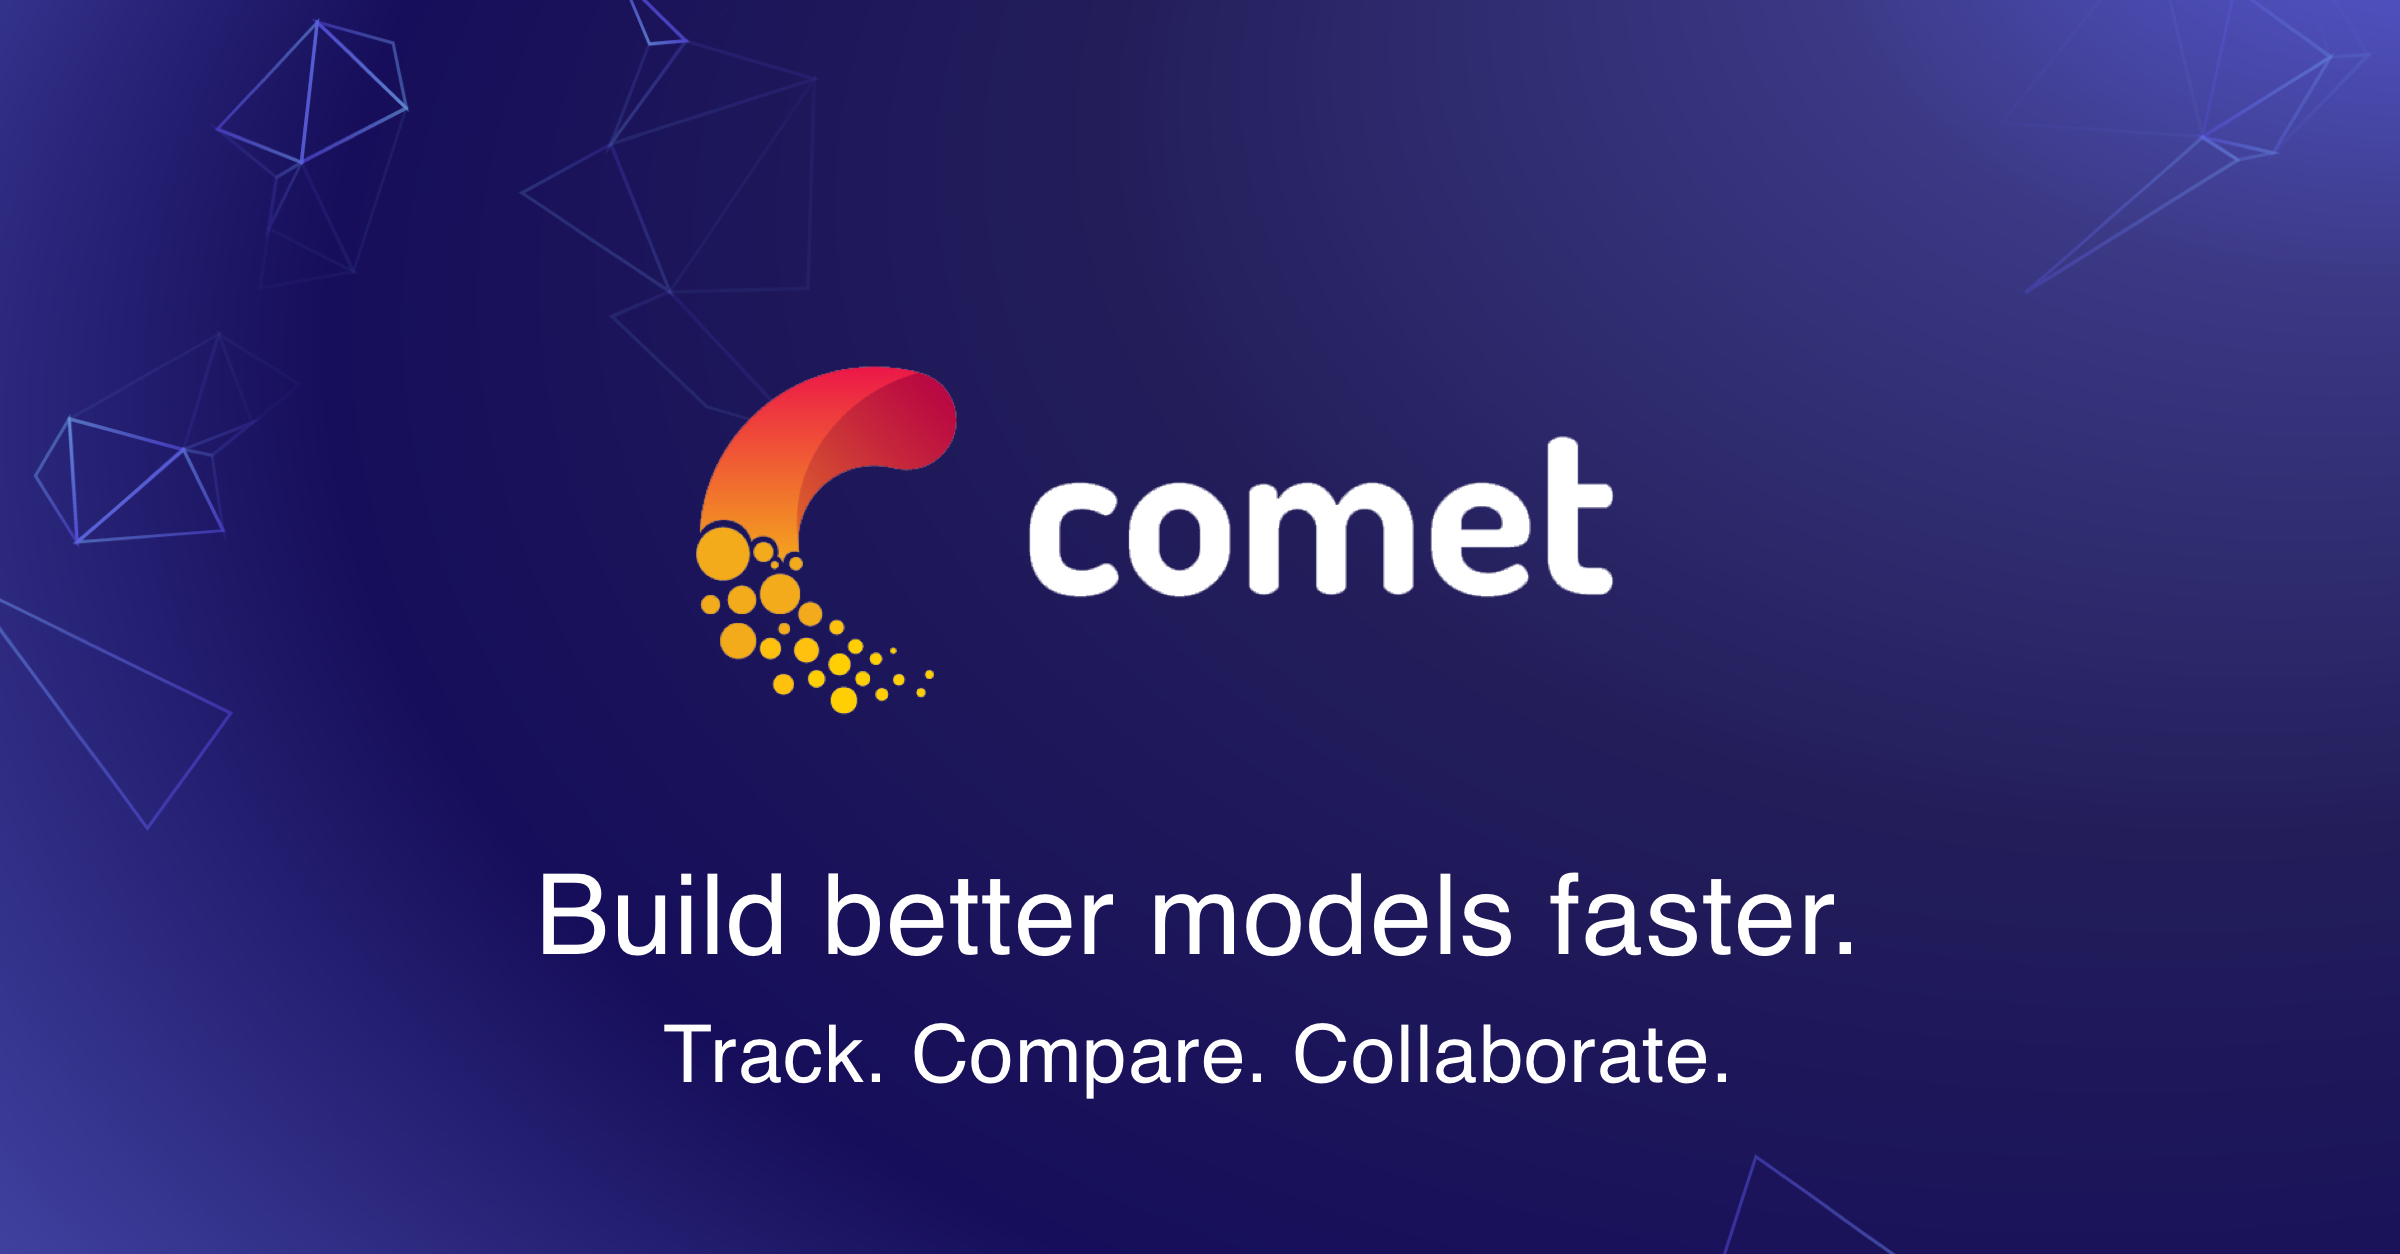

[Comet](https://www.comet.ml/site/data-scientists/?utm_campaign=tensorboardx-integration&utm_medium=colab) is an MLOps Platform that is designed to help data scientists and teams build better models faster! Comet provides tooling to track, evaluate, Manage, and Monitor your traditional, deep learning, and LLM models in a single location.


Comet's Experiment Management is used to track and compare traditional or deep learning training runs in a centralized location. This tutorial is an intro to Comet's Experiment Management capabilities. The concepts covered in this tutorial include:

* Setting up the comet_ml SDK
* Logging a training run to Comet with the Tensorflow integration
* Logging custom data to Comet
* Visualizing your training runs in Comet


# Setup Comet

It take less than 30 seconds to get started with Comet. Start by installing the Comet SDK using `pip`.

In [1]:
! pip install --upgrade comet_ml keras tensorflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 713.5/713.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.7/979.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 10.4 MB/s eta 0:00:00


Next, import Comet into your training script or notebook and set your Comet API Key through environment variables. You can find your API key by clicking on your user icon in the top right corner of the screen and clicking on `API Key`.

We then instantiate a Comet Experiment object through `comet_ml.start()`, which will be automatically logged to throughout this notebook. Click the link to Comet output from this cell to follow along in the UI throughout this tutorial.

In [4]:
import comet_ml

comet_ml.login()
experiment = comet_ml.start(workspace = "comet-demos",project_name="cifar10-vision")

COMET WARNING: Ending the running experiment and creating a new Experiment because:
workspace doesn't match ('comet-demos' != 'None')
project_name doesn't match ('cifar10-vision' != 'None')
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : outdoor_stool_7314
COMET INFO:     url                   : https://www.comet.com/chasefortier/general/94c8c357254449b6b3a06e752e871d3e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [4]                 : (0.15549999475479126, 0.24050000309944153)
COMET INFO:     batch_accuracy [52]          : (0.0625, 0.25)
COMET INFO:     batch_loss [52]              : (1.9291119575500488, 6.313564777374268)
COMET INFO:     epoch_duration [4]           : (1.28

# Setup, Define, and Train Model

We're going to train an image classifier on the CIFAR10 dataset. In this example we use Keras, but Comet integrates seamlessly with any of the common ML frameworks - see our [integration documentation](https://www.comet.com/docs/v2/integrations/overview/) for more information. Through integration with Keras, we will auto-log details about the training in real time without any instrumentation of the code below.



In [6]:
import os
from comet_ml import Artifact

import numpy as np

import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

hyperparams = {
    'batch-size': 16,
    'epochs': 4,
    'filters-layergroup-1': 32,
    'filters-layergroup-2': 64,
    'filters-layergroup-3': 128,
    'dropout-layergroup-1': 0.3,
    'dropout-layergroup-2': 0.5,
    'dropout-layergroup-3': 0.5,
    'optimizer': 'adam', # adam adjusts the learning rate adaptively
    'loss': 'categorical_crossentropy'
}

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use some percentage of the dataset -----
dataset_percentage = 0.04

idx_train = np.arange(len(x_train))
idx_test = np.arange(len(x_test))

x_train = x_train[:int(dataset_percentage*len(idx_train))]
y_train = y_train[:int(dataset_percentage*len(idx_train))]
x_test = x_test[:int(dataset_percentage*len(idx_test))]
y_test = y_test[:int(dataset_percentage*len(idx_test))]
# ------------------------------------------

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# Data Preprocessing

# Converting the pixels data to float type because to_categorical (one hot encoding) needs the data to be of type float by default.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Standardizing: convert all pixel values to values between 0 and 1. (255 is the total number of pixels an image can have)
x_train = x_train / 255
x_test = x_test / 255

# One hot encoding the target class (labels) because the loss function (categorical_crossentropy) used when compiling the model needs data to be one hot encoded.
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def build_model_graph(num_classes):
    model = Sequential()

    model.add(Conv2D(hyperparams['filters-layergroup-1'], (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(hyperparams['filters-layergroup-1'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hyperparams['dropout-layergroup-1']))

    model.add(Conv2D(hyperparams['filters-layergroup-2'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hyperparams['filters-layergroup-2'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hyperparams['dropout-layergroup-2']))

    model.add(Conv2D(hyperparams['filters-layergroup-3'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hyperparams['filters-layergroup-3'], (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hyperparams['dropout-layergroup-3']))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(optimizer=hyperparams['optimizer'], loss=hyperparams['loss'], metrics=['accuracy'])

    return model


model = build_model_graph(num_classes)

model.fit(x_train, y_train,
          batch_size=hyperparams['batch-size'],
          epochs=hyperparams['epochs'],
          shuffle=True,
          validation_data=(x_test, y_test))

2000 train samples
400 test samples
Epoch 1/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.1451 - loss: 3.5745 - val_accuracy: 0.0750 - val_loss: 4.2028
Epoch 2/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1720 - loss: 2.2336 - val_accuracy: 0.1200 - val_loss: 4.8962
Epoch 3/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2052 - loss: 2.1139 - val_accuracy: 0.1500 - val_loss: 4.4157
Epoch 4/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2228 - loss: 2.0823 - val_accuracy: 0.1750 - val_loss: 2.3081


## View Results in the Comet UI

Notice that so far we have not changed our training code to anything Comet specific. This is because Comet integrates with all of the common ML frameworks to [auto-log metadata](https://www.comet.com/docs/v2/guides/experiment-management/log-data/overview/#automated-logging) such as real time metrics during training, git info, installed packages, and system metrics. Code will also be auto-logged when you end the experiment at the end of this notebook.

You can view the results of your training run by navigating to the [Single Experiment Page](https://www.comet.com/docs/v2/guides/experiment-management/analyze-experiments/#single-experiment-page) through the Comet experiment URL output from the first cell, or through the UI.  You should see a number of metrics that have been auto-logged throughout training:

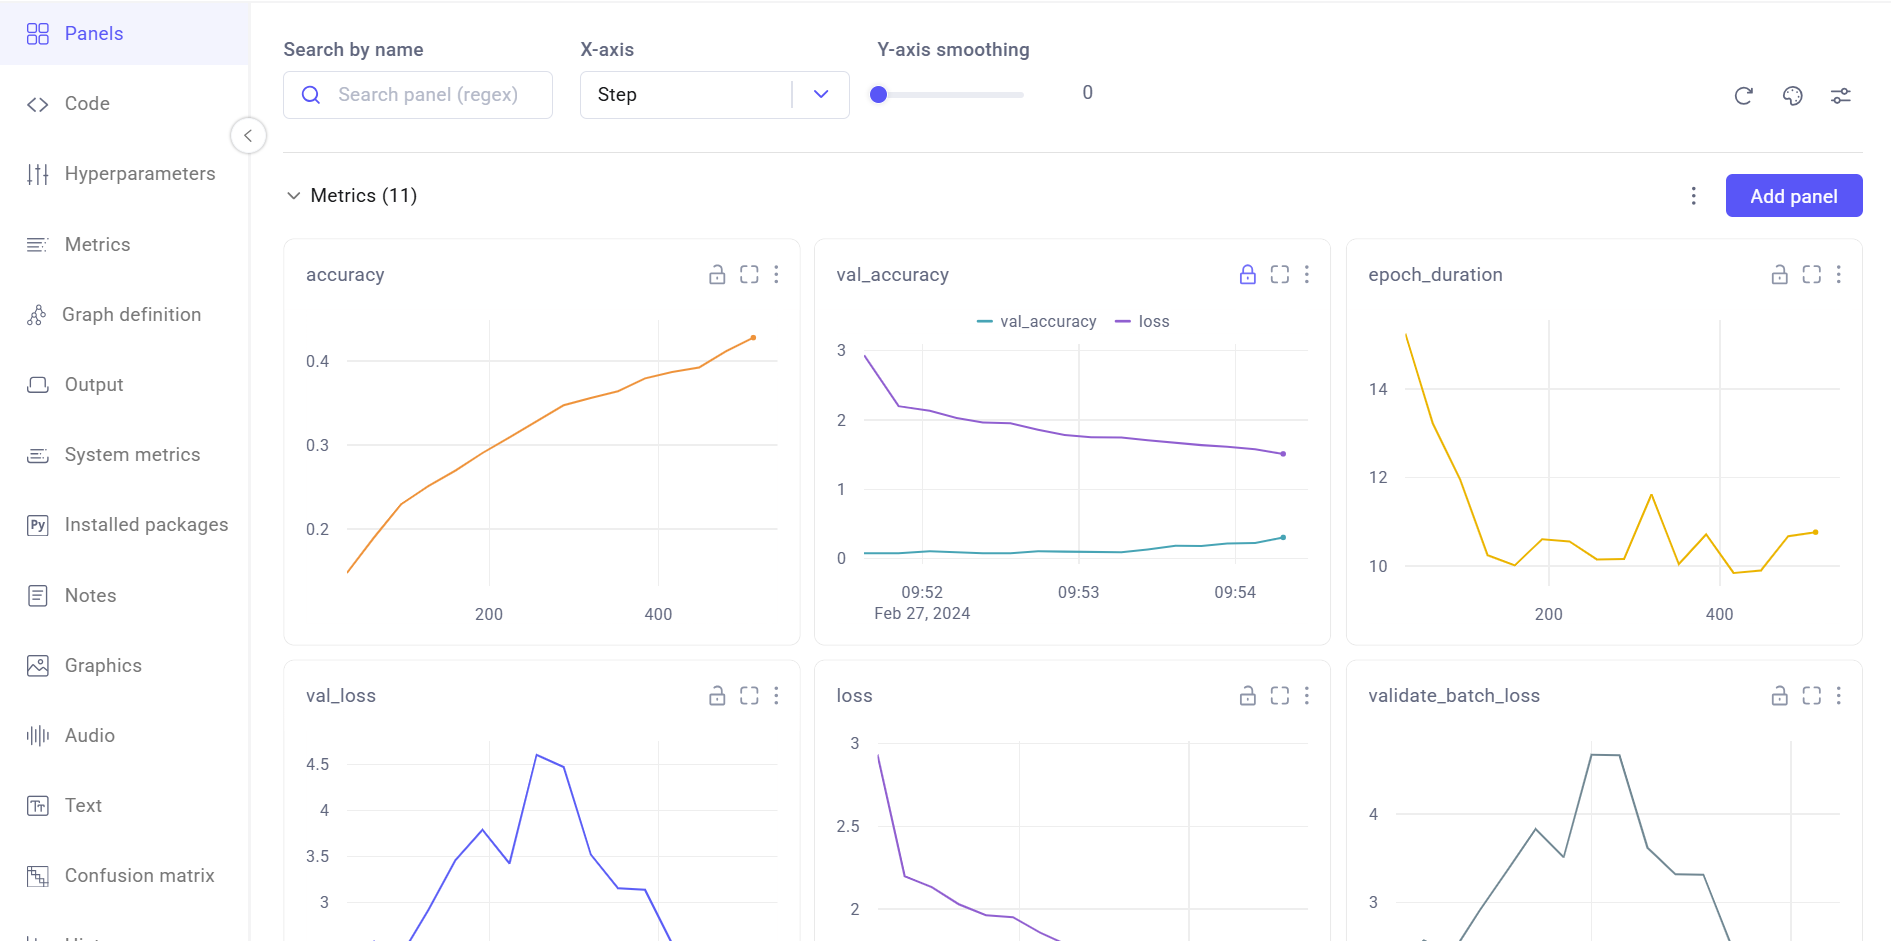

Take a look at the hyperparameters, output, system metrics, and installed packages tabs to see additional auto-logged information for easy debugging and reproducibility.

# Evaluating the Model

Next we'll log a [Confusion Matrix](https://www.comet.com/docs/v2/guides/experiment-management/log-data/confusion-matrix/) to evaluate our model predictions. The Comet Confusion Matrix is interactive, and makes it easy to view misclassified examples in the dataset.

In [7]:
def test_index_to_example(index):
    img = x_test[index]
    data = experiment.log_image(img, name="test_%d.png" % index)
    return {"sample": str(index), "assetId": data["imageId"]}

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
experiment.log_confusion_matrix(y_test, y_pred,
                                labels=class_names,
                                max_examples_per_cell=6,
                                index_to_example_function=test_index_to_example)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


{'web': 'https://www.comet.com/api/asset/download?assetId=2e43a554ba7146318c0bcb65a342a215&experimentKey=3982b0f531e64f51a7b09f2e5b7be9b2',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=2e43a554ba7146318c0bcb65a342a215&experimentKey=3982b0f531e64f51a7b09f2e5b7be9b2',
 'assetId': '2e43a554ba7146318c0bcb65a342a215'}

In the experiment UI, take a look at Confusion Matrix tab to see what was logged. You can click on the cells in the Matrix to display misclassified examples, a helpful tool for debugging.
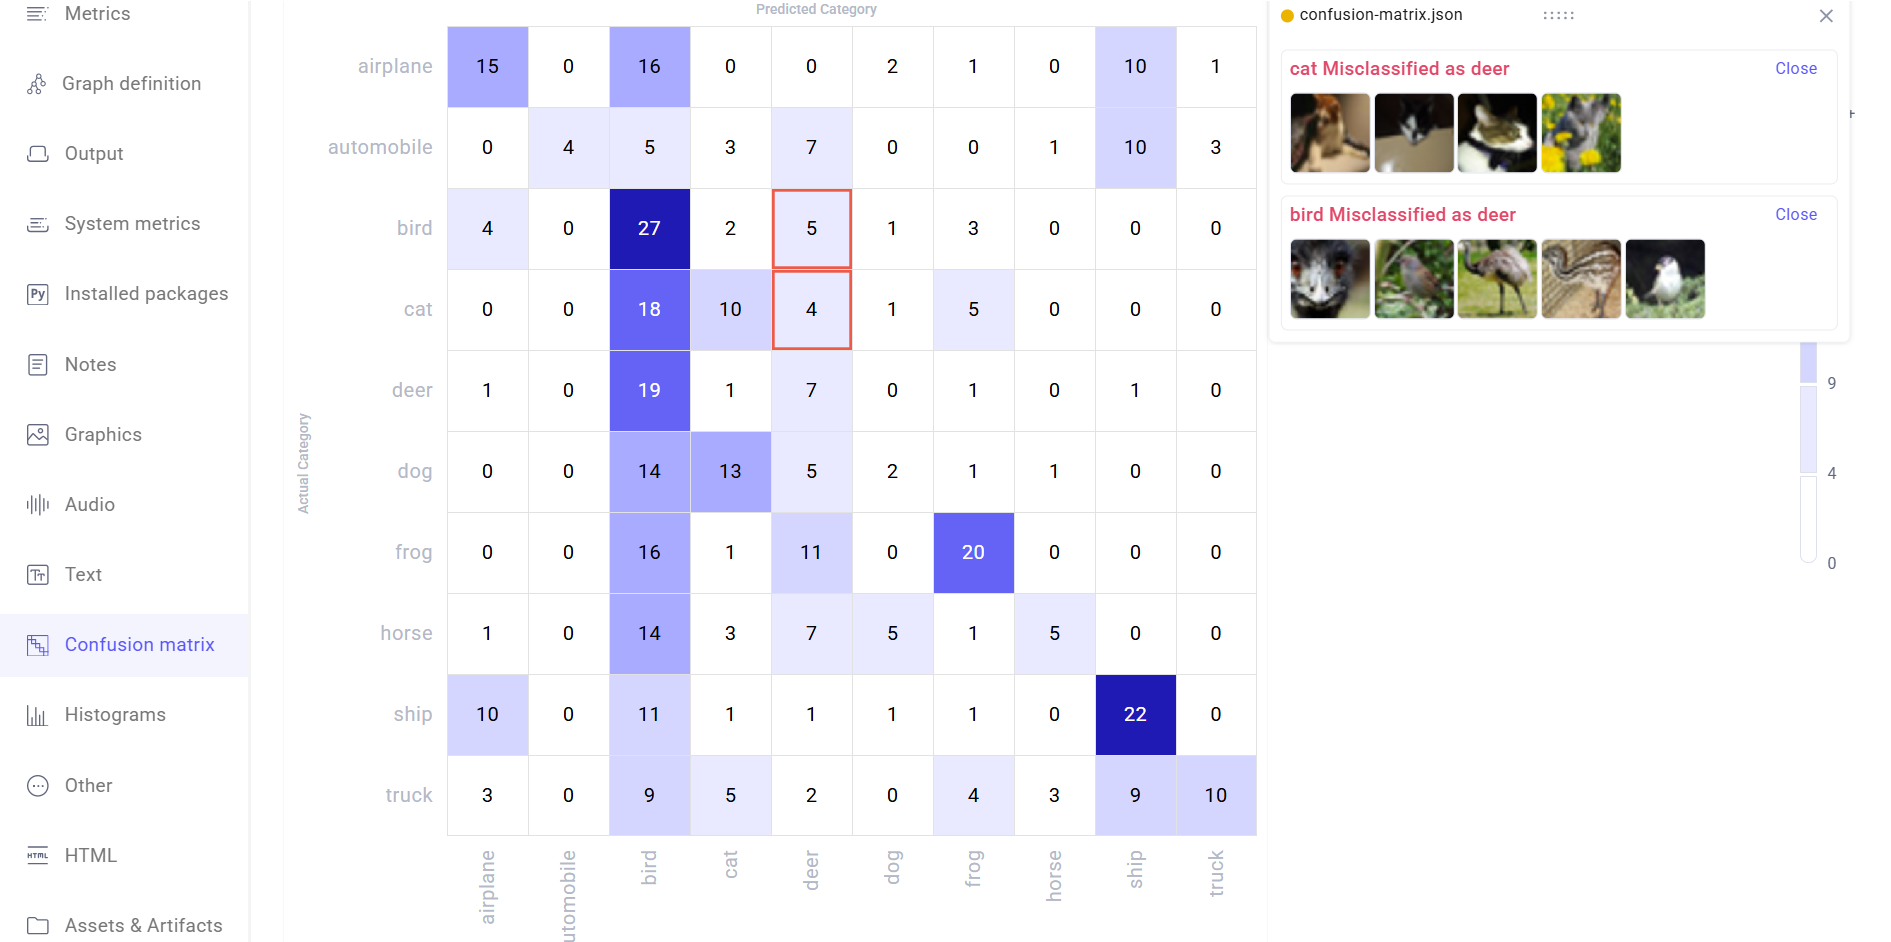

# Log Additional Metadata to Comet

Comet supports logging a wide selection of data types in order to properly track all use cases. This includes (but is not limited to) versioned dataset artifacts, dataframes, audio files, text samples, HTML, models, system metrics, and more.

View our [guides for logging some of the most common data types](https://www.comet.com/docs/v2/guides/experiment-management/log-data/overview/#custom-logging), or our [SDK reference documentation](https://www.comet.ml/docs/v2/api-and-sdk/python-sdk/reference/Experiment/) for a full list of methods that can be used for additional logging.

Below are a few examples of logging additional assets and metadata:


In [8]:
# Log a pointer to your trained model
experiment.log_remote_model(model_name='cifar10-neural-net',
                                uri='s3://sagemaker-eu-north-1/models/cifar10/cifar10-nn-1500.h5')

# log a custom metric
experiment.log_metric('custom_metric', 0.98)

#Add a tag to the model
experiment.add_tag('demo')

# Log other key-value pairs
experiment.log_other('run_id', 1)

# Log a Remote Dataset Artifact
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

artifact = Artifact(
        name="cifar-demo-dataset",
        artifact_type="dataset",
        aliases=["raw"],
        version_tags= ["remote"],
        metadata={"date": date}
    )


artifact.add_remote(uri="s3://comet-ml-demo/data/my-data.csv", metadata={"date": date})

experiment.log_artifact(artifact)

COMET WARNING: boto3 is not installed or cannot be imported and is needed to sync s3:// remote asset urls.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/comet_ml/s3_bucket_info.py", line 118, in preprocess_remote_s3_assets
    import boto3
ModuleNotFoundError: No module named 'boto3'
COMET WARNING: Failed to add remote model synced asset with URI 's3://sagemaker-eu-north-1/models/cifar10/cifar10-nn-1500.h5'. Fallback to not synced mode.
COMET WARNING: boto3 is not installed or cannot be imported and is needed to sync s3:// remote asset urls.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/comet_ml/s3_bucket_info.py", line 118, in preprocess_remote_s3_assets
    import boto3
ModuleNotFoundError: No module named 'boto3'
COMET WARNING: Failed to add remote synced asset with URI 's3://comet-ml-demo/data/my-data.csv'. Fallback to not synced mode.
COMET INFO: Artifact 'cifar-demo-dataset' version 3.0.0 created (previous 

LoggedArtifact(artifact_name='cifar-demo-dataset', artifact_type='dataset', workspace='comet-demos', version=Version('3.0.0'), aliases=frozenset({'raw'}), artifact_tags=frozenset(), version_tags=frozenset({'remote'}), size=0, source_experiment_key='3982b0f531e64f51a7b09f2e5b7be9b2')

In [ ]:
experiment.end()

##  Visualize Cross-Project Results in the Project View

Once you have logged multiple experiments, you can then navigate to the [project page](https://www.comet.com/docs/v2/guides/experiment-management/analyze-experiments/#project-panels-page) to compare across those experiments with Comet's [customizable visualizations](https://www.comet.com/docs/v2/guides/comet-ui/experiment-management/visualizations/overview/) and [dashboard Views](https://www.comet.com/docs/v2/guides/comet-ui/experiment-management/project-pages/project-panels-page/#update-the-dashboard-view) . These Views allow you to create visualization to help determine which experiments were the best and why, so that you can iterate faster.

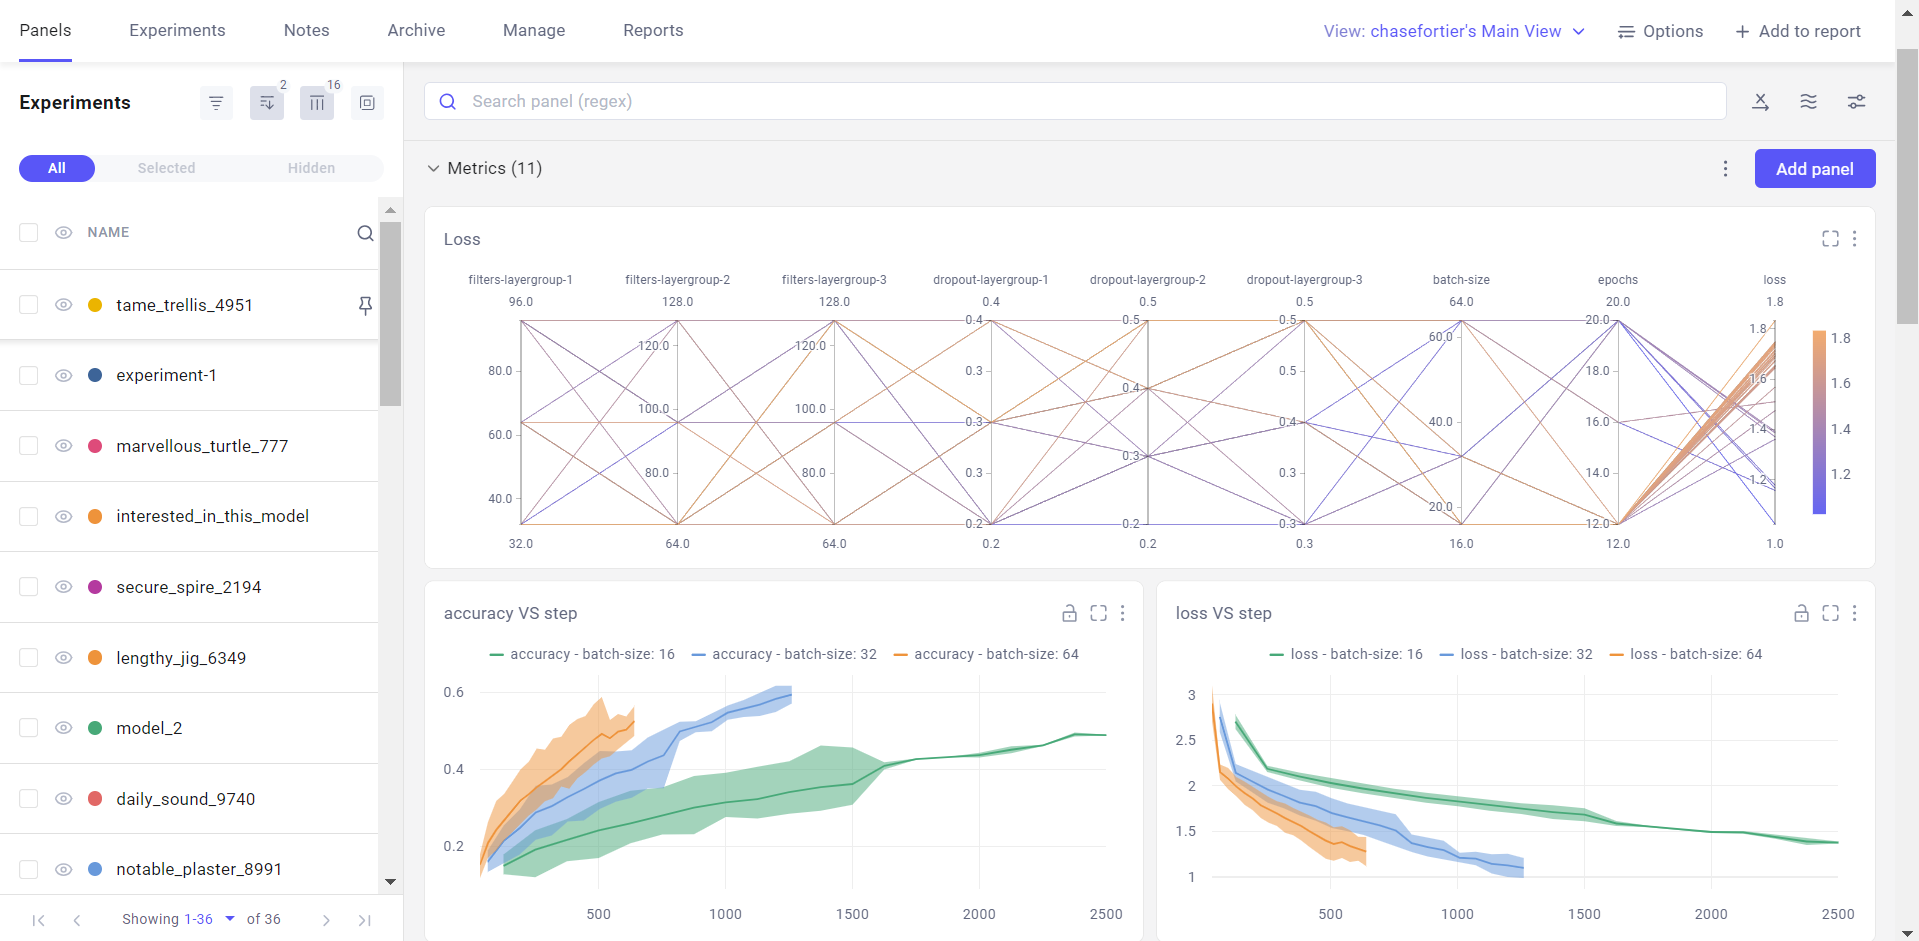



Note that you will need to run the notebook multiple times in order to log multiple experiments, which will show up in the left sidebar of the project. Consider tweaking some of the hyperparameters (ex: batch-size, filters-layergroup-1) on your second run to see how they affect performance.

### Example: Creating a Grouped Line Chart

To add a chart to your view, click on the blue 'Add Panel' button in the top right corner of the screen. Here you will see a number of built in templates to choose from, and even the ability to use your own Python code to create a panel.
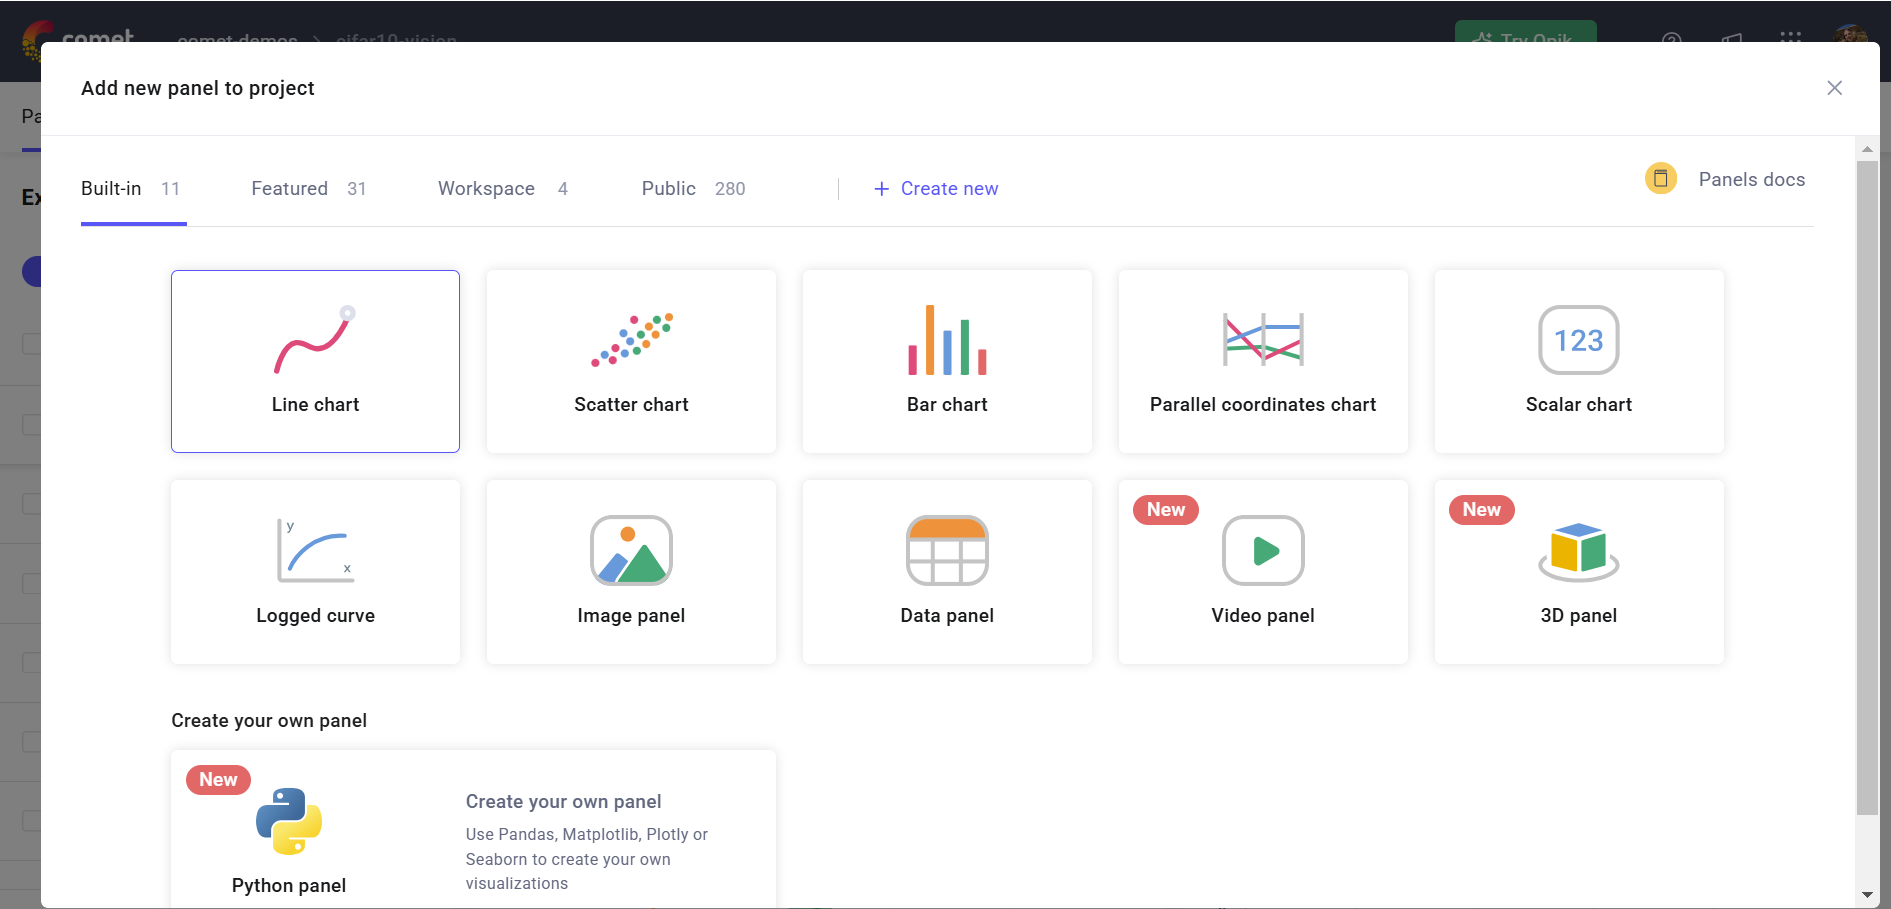

One useful option is a grouped lined chart to see what average performance looks like across different experiment subsets.

Step 1: Select the `Line Chart` panel option

Step 2: Under Y-Axis, select the metric you want to view, such as `accuracy`

Step 3: Toggle to `Group` in the top navigation to configure the group by settings

Step 4: Select the parameter to group by (this should be the same parameter you changed above, such as batch-size)

Step 5: Choose your aggregation and range

Step 6: Click done to add this to your view!

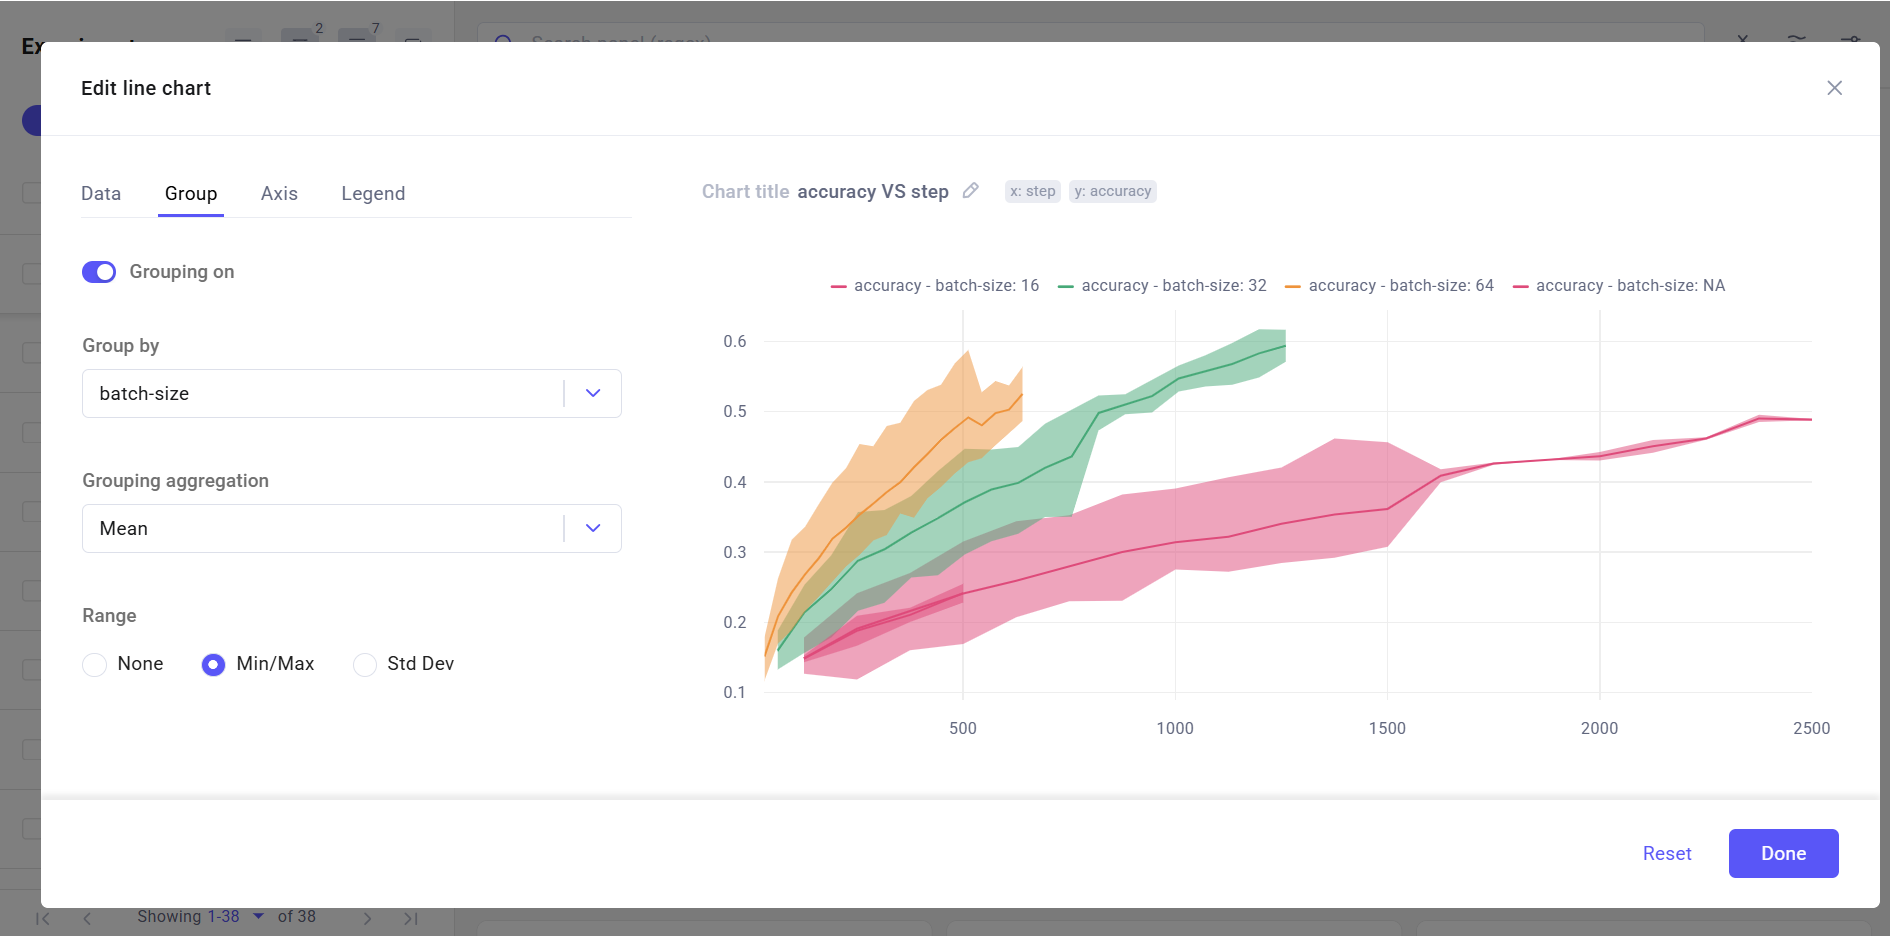




Congrats - you've now logged and visualized your first experiment in Comet! As you log additional experiments, the panels in your view will automatically update to include these new results.

As a next step, try adding the comet_ml SDK to your own code to log and analyze one of your own trainings!